#TRANSITION RATES IN THE “ELECTRICAL” ISING MODEL

### by Daniel Sigg

The “electrical” Ising model is entirely isomorphic to the standard Ising model, so any previous literature dealing with the standard model applies here also. I use a finite model with a 20 x 20 grid, yielding 400 cells.

## Energetics

The system energy for any of the $2^{400}$ configurations is:

$ E = \sum_{i,j} (e_i + e_j - 2e_i e_j )\delta\epsilon - \sum_i \delta q e_i V $,

where index $i$ ranges over all 400 cells and cell values are $e_i = 0$ (resting) or $1$ (activated). Index $j$ covers all nearest-neighbor cells (north, south, east, and west) to cell $i$.

The first sum (interaction term) runs over all nearest-neighbor pairs, with care being taken not to count the same interaction twice. I use periodic boundary conditions. The interaction term is designed so that adjacent cells oriented in the same direction have zero interaction. If they are oppositely aligned, there is an energy penalty of $\delta \epsilon$.

The second sum is the field term, driven by the voltage $V$. As cells flip from resting to activated they move a microscopic gating charge $\delta q$.  Thus the system charge $q = \sum_i \delta q e_i$ ranges from $0$ to $400 q$. I’ve chosen the total gating charge to be 1 eu, so $q = 0.0025$ eu.

The energy $\epsilon_{en}$ of an individual cell can take on 10 values, depending on its own state ($e = 0, 1$) and the number of activated nearest neighbors ($n = 0, 1, 2, 3, 4$). These can be conveniently calculated ahead of time.

The possible values are: $\epsilon_{en} = (2(2-n)\delta\epsilon - \delta q V) e + \delta\epsilon n$

We assume the whole system is in contact with a heat bath at temperature T. I prefer energy units of meV. The corresponding value of Boltzmann’s constant is 0.086174 meV/K, yielding kT = 25 meV at 290 K.

## Kinetics

There are 5 activating and 5 deactivating rate constants $a_i$ that apply to each cell $i$, consistent with the 10 local configurations. The rate constants are a function of the energy needed to activate the cell. This activation energy is equal to:

$\Delta\epsilon_n \equiv \epsilon_{1n} - \epsilon_{0n} - \delta q V = 2(2-n)\delta\epsilon - \delta q V$

Note for $n = 2$, there is no penalty for activation/deactivation provided $V = 0$. The formula describing the value of the 5 activating or "forward" rate constants $\alpha_n$, which applies to a cell originally in the resting state, and surrounded by $n = 0...4$ activated neighbors, is given by:

$\alpha_n = \nu \exp( -x\Delta\epsilon_n/kT)$

where $\nu$ is the pre-exponential factor, and $x$ (the Brønsted slope) is any number between 0 and 1 (usually assigned the value 0.5). I don’t ascribe any temperature-dependence to $\nu$ (implying the microscopic transition is a “bottleneck” or purely entropy-driven event) so that any temperature sensitivity of the macroscopic rate can be attributed to cell-cell interactions.

The corresponding 5 deactivating or “backward” rate constants $\beta_n$ are:

$\beta_n = \nu \exp( (1-x)\Delta\epsilon_n/kT)$

These formulas satisfy detailed balance, as evidenced by:

$\frac{\alpha_n}{\beta_n} = \exp(-\Delta\epsilon_n/kT)$.


## Typical simulation parameters



In [28]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [61]:

# Let's define a IsingSampler object

class IsingSampler(object):
    """An object for performing kinetic Monte Carlo sampling of the 
    'electrical Ising' model. """
    
    def __init__(self, nx=20, ny=20, voltage=0.0, debug=False):
        """Initialize the sampler object."""
        
        self.nx = nx  # number of cells in the x dimension
        self.ny = ny  # number of cells in the y dimension
        self.ncells = nx*ny   # total number of cells
        
        self.debug = debug
        
        # set electrical constants
        self.gating_charge = 1.0  # units eu
        self.dq = self.gating_charge/float(self.ncells)  # the activating charge of each cell
        self.voltage = voltage
        self.k_Boltzmann = 0.086174 # Boltzmann's constant in meV/K
        self.temperature = 290.0 # units K
        self.kT          = self.k_Boltzmann*self.temperature  # 25 meV at 290 K
        self.depsilon    = 24.0  # meV (this is equal to 2J of the standard Ising model) 
        
        # set kinetic Monte Carlo constants
        self.pre_exponential_factor = 2.0e7 # units s^{-1}
        self.Bronsted_slope = 0.5    #
               
        # initialize a random configuration of electric dipoles  e
        self.e = np.random.randint( 2, size=(self.nx, self.ny) )
        if self.debug:
            print 'self.e', self.e
        
        # compile a neighbor list for fast lookup
        self.neighborlist = None
        self.compile_neighborlist()
        
        # initialize the number of activated nearest neighbors
        self.n = self.count_all_activated_neighbors(self.e)   
        if self.debug:
            print 'self.n', self.n
        
        # Calculate the total energy from the states and their neighbors
        self.energy = self.calc_total_energy(self.e, self.n)
        if self.debug:
            print 'self.energy', self.energy
            print 'self.energy/self.kT', self.energy/self.kT
        
        # initialize rate constants for flipping a dipole
        self.alpha_beta = self.calculate_all_alpha_beta(self.e, self.n)
        if self.debug:
            print 'self.alpha_beta', self.alpha_beta
        
        
    def count_all_activated_neighbors(self, e):
        """Count the numbers of north/south/east/west neighbors that
        are activated."""
        
        n = np.zeros( e.shape, dtype=int) 
        
        for i in range(self.nx):      
            for j in range(self.ny):
                n[i,j] = self.count_activated_neighbors(e, i, j)
        return n

    def compile_neighborlist(self):
        """Construct a lookup table for periodic-boundary neighbor indices."""
        self.neighborlist = np.zeros( (self.nx, self.ny, 4, 2), dtype=int)
            # [i,j,:,:]  = [[inorth, jnorth],
            #               [isouth, jsouth],
            #               [iwest,  jwest],
            #               [ieast,  jeast]]

        for i in range(self.nx):
            for j in range(self.ny):
                self.neighborlist[i,j,0,:] = [i, (j-1)%(self.ny)]
                self.neighborlist[i,j,1,:] = [i, (j+1)%(self.ny)]
                self.neighborlist[i,j,2,:] = [(i-1)%(self.nx), j]
                self.neighborlist[i,j,3,:] = [(i+1)%(self.nx), j]

    
    def count_activated_neighbors(self, e, i, j):
        """Count the number of activated neighbors for a particular i,j cell."""
        
        count = 0
        for k in range(4):
            count += e[self.neighborlist[i,j,k,0],self.neighborlist[i,j,k,1]]       
        return count


    
    def calc_total_energy(self, e, n):
        """Calculate the energy of the input state
        
        INPUT
        e     - an nx,ny array of 0 (resting) or 1 (activated)"""
        
        energy = 0.0
        for i in range(self.nx):
            for j in range(self.ny):
                
                energy +=  -1.0*self.dq*float(e[i,j])*self.voltage
                
                if e[i,j] == 0:
                    # NOTE divide by 2 to avoid double-counting
                    energy += n[i,j]*self.depsilon / 2.0 
                else:
                    energy += (4.0-n[i,j])*self.depsilon / 2.0 

        return energy 
 

    def calculate_all_alpha_beta(self, e, n):
        """Calculate activating/deactivating rate constants for each cell"""
        
        alpha_beta = np.zeros( e.shape, dtype=float)
        for i in range(self.nx):
            for j in range(self.ny):
                
                if e[i,j] == 0:
                    alpha_beta[i,j] = self.calculate_alpha(n, i, j)
                else:
                    alpha_beta[i,j] = self.calculate_beta(n, i, j)

                    
        return alpha_beta
                

    def activation_energy(self, n, i, j):     
        """Calculate the 0->1 activation energy for a particular i,j cell."""   
        activation_energy = 2.0*(2.0 - n[i,j])*self.depsilon - 1.0*self.dq*self.voltage
        return activation_energy
    
    
    def calculate_alpha(self, n, i, j):
        """Calculate activating rate constant 0->1 for a particular i,j cell"""   
        return self.pre_exponential_factor*np.exp(-self.Bronsted_slope*self.activation_energy(n,i,j)/self.kT)
    

    def calculate_beta(self, n, i, j):
        """Calculate de-activating rate constant 1->0 for a particular i,j cell"""    
        return self.pre_exponential_factor*np.exp((1.-self.Bronsted_slope)*self.activation_energy(n,i,j)/self.kT)
    
    
    
    def sample(self, nsteps):
        """Perform kinetic Monte Carlo """
        
        # keep track of trajectories
        time = [0.0]
        state = [ np.copy(self.e.ravel()) ]
        
        print_every = 10000
        
        for step in range(nsteps):
            
            # Sum all the previously assigned rate constants ai together to obtain the total rate constant a
            # of leaving the current configuration. 
            total_rate_a = self.alpha_beta.sum()
        
            # Then pick a uniform random number r1
            r1 = np.random.rand()
            # ... and calculate the exponentially distributed dwell time
            # using the formula:
            tau = -np.log(r1)/total_rate_a

            # Pick a second random number r2 in order to determine which cell to flip.
            # Each cell has probability ai/a of being chosen.
            p = self.alpha_beta.ravel()/total_rate_a
            r2 = np.random.rand()
            flip_index = -1
            p_cumulative = 0.0
            while r2 > p_cumulative:
                p_cumulative += p[flip_index+1]
                flip_index += 1
            if self.debug:
                print 'r2', r2, 'flip_index', flip_index,

            iflip, jflip = np.unravel_index(flip_index, (self.nx,self.ny))
            if self.debug:
                print 'iflip, jflip', iflip, jflip
                
            # update the energy
            if self.e[iflip,jflip] == 1:  # the move will be 1->0
                self.energy -= self.activation_energy(self.n,iflip,jflip)
            else: # the move will be 0->1
                self.energy += self.activation_energy(self.n,iflip,jflip)

            # flip the selected cell
            self.e[iflip,jflip] = int(self.e[iflip,jflip]==0)
            

            
            # update the neighboring neighbor counts
            if self.e[iflip,jflip] == 1:  # the flip is 0 --> 1; add +1 to neighbor counts
                for k in range(4):
                    self.n[ self.neighborlist[iflip,jflip,k,0],self.neighborlist[iflip,jflip,k,1]] += 1      
            else:  # the flip is 0 --> 1; subtract 1 from neighbor counts
                for k in range(4):
                    self.n[ self.neighborlist[iflip,jflip,k,0],self.neighborlist[iflip,jflip,k,1]] -= 1      
            
            # update the rates for the flipped cell,          
            if self.e[iflip,jflip] == 0:
                self.alpha_beta[iflip,jflip] = self.calculate_alpha(self.n, iflip, jflip)
            else:
                self.alpha_beta[iflip,jflip] = self.calculate_beta(self.n, iflip, jflip)

            # ...and occasionally check to see if our energy calculation is correct
            if step%print_every == 0:
                print 'From on-the-fly updating: self.energy =', self.energy,
                print 'From total re-calc:       self.energy =', self.calc_total_energy(self.e, self.n)


            
            # append a snapshot to the the trajectory
            time.append( time[-1]+tau )
            state.append( np.copy(self.e.ravel()) )
            
            if step%print_every == 0:
                print 'step', step, 'of', nsteps
            
        return time, state
    
    

In [63]:
s = IsingSampler()
#print s.e.ravel()
time, state = s.sample(1000000)
#print 'time, state', time, state


From on-the-fly updating: self.energy = 9744.0 From total re-calc:       self.energy = 9744.0
step 0 of 1000000
From on-the-fly updating: self.energy = 2448.0 From total re-calc:       self.energy = 2448.0
step 10000 of 1000000
From on-the-fly updating: self.energy = 1488.0 From total re-calc:       self.energy = 1488.0
step 20000 of 1000000
From on-the-fly updating: self.energy = 384.0 From total re-calc:       self.energy = 384.0
step 30000 of 1000000
From on-the-fly updating: self.energy = 1632.0 From total re-calc:       self.energy = 1632.0
step 40000 of 1000000
From on-the-fly updating: self.energy = 768.0 From total re-calc:       self.energy = 768.0
step 50000 of 1000000
From on-the-fly updating: self.energy = 1200.0 From total re-calc:       self.energy = 1200.0
step 60000 of 1000000
From on-the-fly updating: self.energy = 768.0 From total re-calc:       self.energy = 768.0
step 70000 of 1000000
From on-the-fly updating: self.energy = 768.0 From total re-calc:       self.energ

In [64]:
print time[-1]

0.00040591685418


In [104]:
# Let's define a Trajectory Object

class Trajectory(object):
    """An object to hold kinetic Monte Carlo trajectories (non-discrete time jumps), 
    with methods to convert to discrete-time MSM trajectories."""
    
    def __init__(self):
        """Initialize the trajectory object."""
        
        self.nframes = 0
        self.times   = []  # storage for (non-discrete) time points
        self.states  = []  # storage for ravel()'ed dipole states
        

### animations!

Following instructions from http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/



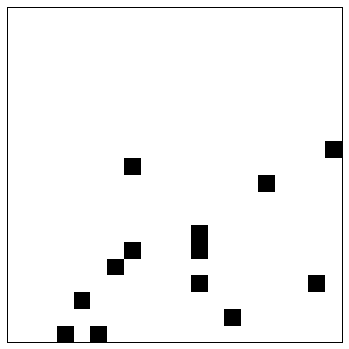

In [65]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots( figsize=(6,6) )

ax.set_xlim(( 0, 20))
ax.set_ylim((0, 20))
plt.xticks([])
plt.yticks([])

#line, = ax.plot([], [], lw=2)
#pmesh = ax.pcolormesh([], [], [])


#y, x = np.meshgrid(np.linspace(0,20,1), np.linspace(0,20,1))
#z = np.sin(x**2+y**2)
#z = z[:-1, :-1]

# z = np.random.randint( 2, size=(20,20) )
# print z


z = state[0].reshape( (20,20))
quad = plt.pcolor(z, cmap='Greys')


# initialization function: plot the background of each frame
def init():
    z = state[0].reshape( (20,20))
    #quad = plt.pcolor(z, cmap='Greys')

    quad.set_array(np.nan)
    return (quad,)

# animation function. This is called sequentially
def animate(i, stride=1000):
    z = state[stride*i].reshape((20,20))
    #quad = plt.pcolor(z, cmap='Greys')
    quad.set_array(z.ravel())
    #plt.title('Phase: %.2f'%i)
    return (quad,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=20, blit=True)

HTML(anim.to_html5_video())